# Principal component analysis
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie

Notebook released under the Creative Commons Attribution 4.0 License.

---
Principal component analysis (PCA) constructs a set of orthogonal lines of best fit for a dataset. It works by iteratively finding the vector that maximally explains the variance in the data and is orthogonal to all vectors chosen previously. Note that this is a different definition of "best fit" than OLS. The best way to understand PCA is to look at a picture:

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [110]:
# Import the data we want to model
start = '2014-01-01'
end = '2015-01-01'
r1 = get_pricing('MSFT', fields='price', start_date=start, end_date=end).pct_change()[1:]
r2 = get_pricing('SPY', fields='price', start_date=start, end_date=end).pct_change()[1:]

In [122]:
# Run the PCA
pca = PCA() # Create an estimator object
pca.fit(np.vstack((r1,r2)).T)
components = pca.components_
evr = pca.explained_variance_ratio_
print 'PCA components:\n', components
print 'Fraction of variance explained by each component:', evr

PCA components:
[[ 0.92066823  0.39034602]
 [ 0.39034602 -0.92066823]]
Fraction of variance explained by each component: [ 0.84258296  0.15741704]


The principal components are linear combinations of the dataset. Here the first principal component is .92 times the first variable and .39 times the second.

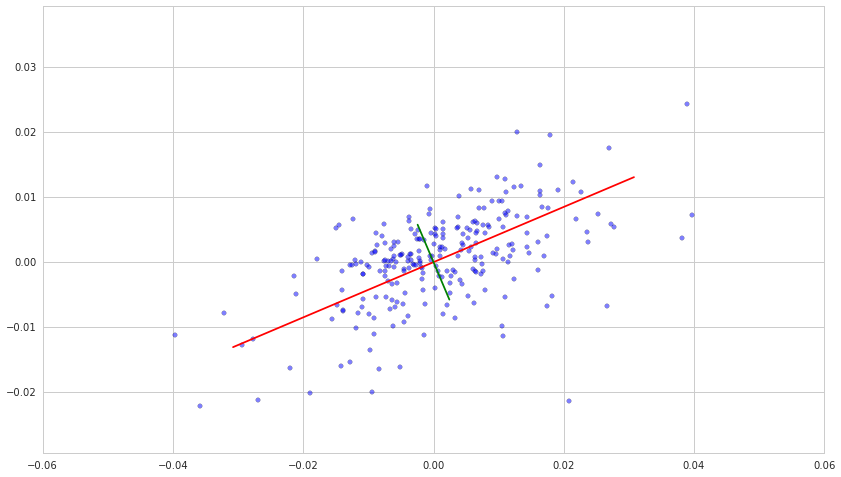

In [126]:
# Plot the data
plt.scatter(r1,r2,alpha=0.5)

# Plot the component vectors returned by PCA
xs = np.linspace(r1.min(), r1.max(), 100)
plt.plot(xs*components[0,0]*evr[0], xs*components[0,1]*evr[0], 'r')
plt.plot(xs*components[1,0]*evr[1], xs*components[1,1]*evr[1], 'g')

# Set 1:1 aspect ratio
plt.axes().set_aspect('equal', 'datalim')

The red line above is the first principal component, and it shows the direction along which the data is most stretched. This is the line of best fit in the sense that it minimizes the sum of squared distances of points from the line (this is different from OLS, which uses the vertical distances only). Since our data is only two-dimensional, there is only one choice for the second principal component. If there were more dimensions, it would be the line in the plane orthogonal to the first line which is in the direction in which the data is most distributed. This can be thought of as fitting an ellipsoid to the data: the principal components are then the axes of the ellipse.

To plot them, we've scaled the vectors so that the ratio of their lengths is the ratio of the amount of variance they explain. We can see that the red one is much longer, which demonstrates why it was the first principal component to be selected.

We can use the principal components by themselves to represent the data, as we often do with regression lines. We can also write the data in terms of the components, using them as basis vectors of an alternate coordinate system.

## Dimensionality reduction

If our data is $n$-dimensional, we can pick up to $n$ principal components (as we did above, where $n=2$). However, since the components get less and less useful, we often want to cut the algorithm short and only use the first few. This is easily done by specifying the number of components desired when runing the algorithm, or simply by ignoring the ones we don't need (since they are chosen iteratively, the lack of later components doesn't change the earlier ones). The PCA class we used above also has the option picking components up until a certain percentage of the variance has been explained, or using MLE (maximum likelihood estimation) to guess the correct number of components. 

In [198]:
# Import a larger-dimension dataset
assets = ['SPY', 'XLE', 'XLY', 'XLP', 'XLI', 'XLU', 'XLK', 'XBI', 'XLB', 'XLF', 'GLD']
returns = get_pricing(assets, fields='price', start_date=start, end_date=end).pct_change()[1:]
print 'Dimension of data:', len(assets)

# Get principal components until 90% of variance is explained
pca_pv = PCA(0.9)
pca_pv.fit(returns)
components_pv = pca_pv.components_
evr_pv = pca_pv.explained_variance_ratio_
print '\nFraction of variance explained by each component up to 0.9 total:', evr_pv

# Get principal components, number of components determined by MLE
pca_mle = PCA('mle')
pca_mle.fit(returns)
evr_mle = pca_mle.explained_variance_ratio_
print '\nNumber of principal components using MLE:', len(evr_mle)
print 'Fraction of variance explained by each component using MLE:', evr_mle

Dimension of data: 11

Fraction of variance explained by each component up to 0.9 total: [ 0.57890485  0.19019185  0.08487885  0.05529814]

Number of principal components using MLE: 10
Fraction of variance explained by each component using MLE: [ 0.57890485  0.19019185  0.08487885  0.05529814  0.04110921  0.01198353
  0.01074983  0.01020336  0.00864709  0.00771259]


This reduces the dimension of our data with minimal information loss. Dimensionality reduction is useful for filtering out noise and making the data more manageable, among other things.

## Considerations

For PCA to work, we must first subtract the mean from each component of the data so that it is centered at the origin. The class we used above does this for us.

PCA, like linear regression, is sensitive to the scaling of the data. Therefore, the data is often standardized before running the analysis so that all variables have variance 1, particularly if the series in the dataset have different units. We did not do this above since we were comparing returns with other returns, so it was reasonable to use the raw data. If we did want to standardize the data, it would look like this:

PCA components:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
Fraction of variance explained by each component: [ 0.78005181  0.21994819]


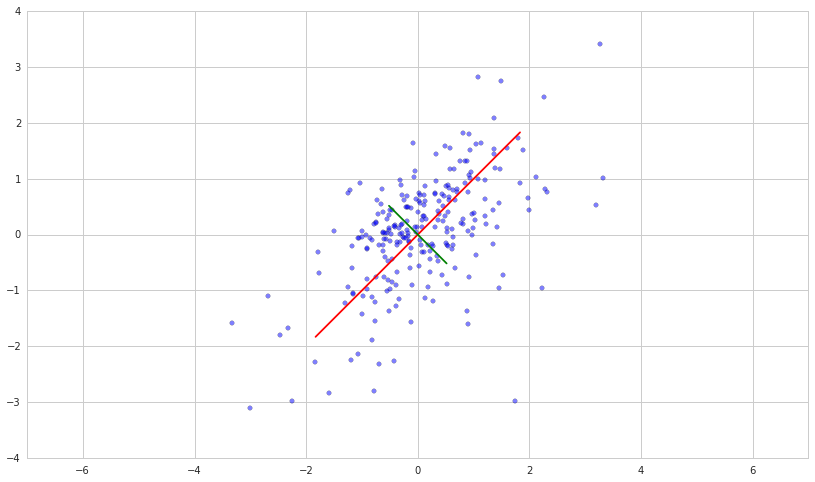

In [132]:
r1_s = r1/r1.std()
r2_s = r2/r2.std()

pca.fit(np.vstack((r1_s,r2_s)).T)
components_s = pca.components_
evr_s = pca.explained_variance_ratio_
print 'PCA components:\n', components_s
print 'Fraction of variance explained by each component:', evr_s

# Plot the data
plt.scatter(r1_s,r2_s,alpha=0.5)

# Plot the component vectors returned by PCA
xs = np.linspace(r1_s.min(), r1_s.max(), 100)
plt.plot(xs*components_s[0,0]*evr_s[0], xs*components_s[0,1]*evr_s[0], 'r')
plt.plot(xs*components_s[1,0]*evr_s[1], xs*components_s[1,1]*evr_s[1], 'g')

# Set 1:1 aspect ratio
plt.axes().set_aspect('equal', 'datalim')

## Statistical factor models

Recall that a factor model expresses the returns as

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

where the $F_j$ are some systemic factors, the $b_{ij}$ are the sensitivities of $R_i$ to those factors, and $\epsilon_i$ represents the asset-specific risk. We can use PCA to compute the factors that best describe returns without specifying what the factors represent. These factors will be portfolios of the assets we are considering. After we pick the portfolios we want to use as factors and compute their returns, we can estimate the loadings with linear regression.

Below, we go back to our PCA which found components to explain 90% of the variance in a large dataset, and use those components as factors to model one of the assets.

In [201]:
import statsmodels.api as sm
from statsmodels import regression

# Compute returns on factor i, which are returns on portfolio with weights components_pv[i], for all i
factor_returns = np.array([(components_pv[i]*returns).T.sum()
                           for i in range(len(components_pv))])

# Regress first asset against the factors
mlr = regression.linear_model.OLS(returns.T.iloc[0], sm.add_constant(factor_returns.T)).fit()
print 'Regression coefficients for %s\n' % assets[0], mlr.params

Regression coefficients for SPY 
const    0.000028
x1       0.231881
x2      -0.217134
x3       0.062124
x4       0.041192
dtype: float64
